(0.0, 20.0)

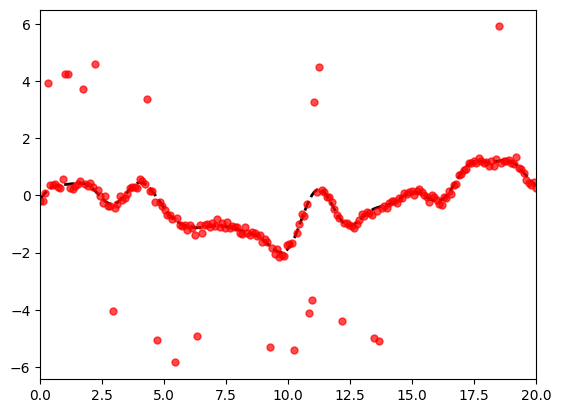

In [6]:
from typing import Optional

import tensorflow as tf
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast
import tensorflow_probability as tfp
import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye
import random
import w 

import tensorflow as tf
import numpy as np
import gpflow

import matplotlib.pyplot as plt
tf.keras.config.set_floatx('float64')
seed = 10

#set seed
np.random.seed(seed)
tf.random.set_seed(seed)

#create X
n_points = 200
sigma_n = 0.1
#percentage of points in x which are biased
percent_miss=0.1


#
lengthscale = 1
variance = 1

variance_out = 2

kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance)

x = np.linspace(0, 20, n_points).reshape(n_points, 1)
f = np.random.multivariate_normal(mean=np.zeros(len(x)) ,cov=kernel(x, x)).reshape(n_points, 1)

i_obs = np.random.choice(
    np.arange(0, n_points, 1), int( n_points), replace=False)

y_obs = f[i_obs] + np.random.normal(scale=sigma_n, size=n_points).reshape(n_points, 1)
x_obs = x[i_obs]

arr1inds = x_obs[:,0].argsort()
x_obs = x_obs[arr1inds]
y_obs = y_obs[arr1inds]

i_mis = np.random.choice(
    np.arange(0, n_points, 1), int(percent_miss * n_points), replace=False)

y_mis_pos = y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]]  + np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]>0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]>0)[:,0]]),1)
y_mis_neg = y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]]  - np.random.uniform(3, 5, size=len(i_mis[(y_obs[i_mis]<=0)[:,0]])).reshape(len(i_mis[(y_obs[i_mis]<=0)[:,0]]),1)
y_obs[i_mis[(y_obs[i_mis]>0)[:,0]]] = y_mis_pos
y_obs[i_mis[(y_obs[i_mis]<=0)[:,0]]] = y_mis_neg
X=x
y=y_obs

plt.plot(x, f, color='black', ls='--', lw=2)
plt.plot(x_obs, y_obs, 'r.', ms=10, alpha=0.7)
plt.xlim(x[0], x[-1])

In [7]:
standard_gp = gpflow.models.GPR(
    (x_obs, y_obs),
    kernel=gpflow.kernels.SquaredExponential(lengthscales=lengthscale, variance=variance),
    noise_variance=sigma_n**2
)

f_mean, f_var = standard_gp.predict_f(x, full_cov=False)

f_std = np.sqrt(f_var)

/var/folders/3j/3sftgpw558d6tvmshw2b29jc0000gn/T/ipykernel_3355/307137617.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


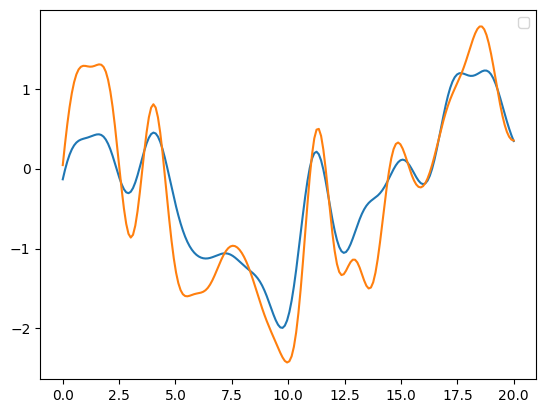

In [8]:
plt.plot(x,f)
plt.plot(x,f_mean)
plt.legend()

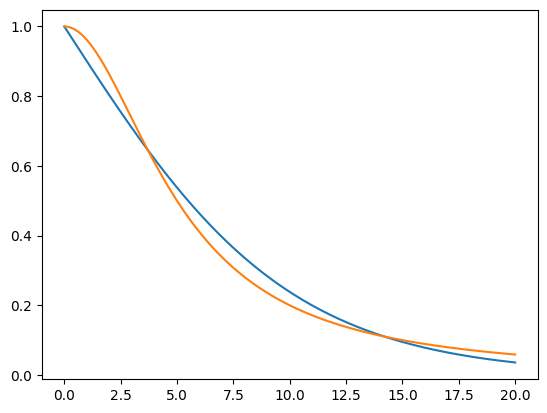

In [9]:
def weight1(x,c=5):
    return 2/(1+np.exp(x/c))
def weight2(x,c=5):
    return 1/(1+(x/c)**2)

plt.plot(x,weight1(x))
plt.plot(x,weight2(x))

THIS IS THE FIRST PROPOSED MODEL, CORRESPONDING TO THE RCGP-alpha

In [10]:

@tf.function
def update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma_2, Y_train, mu_w):
    q1 = tf.linalg.inv(alpha * Sigma_a_inv + 2 * J_w_inv / sigma_2)
    q2 = tf.matmul((2 * J_w_inv / sigma_2), (Y_train - mu_w))
    return tf.matmul(q1, q2)



def divide_batch(X, y, test_ratio=0.2, seed=None):
    if seed is None:
        seed = np.random.uniform(0, 1000)

    random.seed(seed)

    # Get the number of samples
    n = tf.shape(X)[0]
    num_test = tf.cast(tf.math.round(test_ratio * tf.cast(n, tf.float32)), tf.int32)

    # Shuffle indices
    indices = tf.range(n)
    shuffled_indices = tf.random.shuffle(indices)

    # Split indices
    test_indices = shuffled_indices[:num_test]
    train_indices = shuffled_indices[num_test:]

    # Split data
    X_train = tf.gather(X, train_indices)
    X_test = tf.gather(X, test_indices)
    Y_train = tf.gather(y, train_indices)
    Y_test = tf.gather(y, test_indices)
    return X_train, Y_train, X_test, Y_test, train_indices, test_indices


def maximize_c(y, quant):
    return np.quantile(abs(y), 1 - quant)


def Full_sample_estimate(variance, lengthscale, X, w_full, c_f, alpha, Y):
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    #update quantitites, Sigma_a,J_w
    w_full = sigma / (2 ** 0.5) * w_full
    J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, -2))) * sigma ** 2 / 2
    J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_full, 2))) * 2 / (sigma ** 2)

    Sigma_f = (c_f * K @ tf.linalg.inv(K + sigma ** 2 / 2 * J_w) * sigma ** 2 / 2) @ J_w

    Sigma_a = alpha * K + (1 - alpha) * Sigma_f
    Sigma_a_inv = tf.linalg.inv(Sigma_a)

    mu_f = update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y, m_w_full)
    return (mu_f, Sigma_f)



import random
import w
c = maximize_c(y, 0.1)

W = w.IMQ(c)
w_full = tf.cast(W.W(X, y), dtype=tf.float64)
m_w_full = W.dy(X, y) ** 2



sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
c_f = tf.Variable(1., dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(4.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(.9, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
alpha = tf.Variable(0.5, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, -1, 2))


def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

import tensorflow_probability as tfp

for i in range(500):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.1)
        n_test = X_test.shape[0]
        #estimate Gpflow kernel.
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X_train, X_train)

        new_ind = list(train_indices.numpy())
        #update quantitites, Sigma_a,J_w
        w_train = tf.gather(w_full, train_indices)
        m_w = tf.gather(m_w_full, train_indices)
        J_w = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, -2)))
        J_w_inv = tf.linalg.tensor_diag(tf.squeeze(tf.math.pow(w_train, 2)))

        Sigma_f = (c_f * K @ tf.linalg.inv(K + sigma ** 2 / 2 * J_w) * sigma ** 2 / 2) @ J_w

        Sigma_a = alpha * K + (1 - alpha) * Sigma_f
        Sigma_a_inv = tf.linalg.inv(Sigma_a)

        mu_f = update_mu_f(alpha, Sigma_a_inv, J_w_inv, sigma ** 2, Y_train, m_w)
        K_star = tf.transpose(kernel.matrix(X_test, X_train))
        K_star_star = kernel.matrix(X_test, X_test)

        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K) @ mu_f
        sigma_f_pred = K_star_star
        sigma_f_pred = sigma_f_pred - c_f * tf.transpose(K_star) @ tf.linalg.inv(K + sigma ** 2 * J_w) @ K_star
        sigma_f_pred = sigma_f_pred + (c_f - 1) * tf.transpose(K_star) @ tf.linalg.inv(K) @ K_star + tf.linalg.eye(
            n_test, dtype=tf.float64) * sigma**2
        sigma_f_pred=tf.linalg.diag_part(sigma_f_pred)#*tf.gather(w_full, test_indices)**(-2)
        vv = tfp.distributions.Normal(mu_f_pred, sigma_f_pred)
        loss = vv.log_prob(Y_test)
    grad = tape.gradient(loss, [c_f, sigma, variance, lengthscale, alpha])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [c_f, sigma, variance, lengthscale, alpha]))

Mu_full, Sigma_full1 = Full_sample_estimate(variance, lengthscale, X, w_full, c_f, alpha, y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
print(tf.reduce_mean((f-Mu_full)**2),tf.reduce_mean(abs(f-Mu_full)),"rcgp_alpha mean")
alpha

tf.Tensor(0.032801923460654345, shape=(), dtype=float64) tf.Tensor(0.1337179134545069, shape=(), dtype=float64) rcgp_alpha mean


<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5139999065396532>

Here is the LOSS predictive with c defined based on a fixed proportion of outliers, and the loss being the expected MSE(mean+variance)

In [14]:
sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
W=tf.eye(N,N,dtype=tf.float64)*sigma**2
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(1000):
    print(i)
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    K_plus_W_inv=tf.linalg.inv(K+W)
    K_plus_W_inv_y=K_plus_W_inv@y
    mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
    sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
    LOO_probs=(tf.squeeze(y)-mean_loo)
    def maximize_c(y, quant):
        return np.quantile(abs(y), 1 - quant)
    c=maximize_c(y-mean_loo,0.1)

    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        LOO_probs=1/(1+LOO_probs**2/c**2)
        sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo)**2))
        W=tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs)/LOO_probs)
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        K_plus_W_inv_y=K_plus_W_inv@y
        mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
        sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
        """vv = tfp.distributions.Normal(mean_loo, sigma_loo)
        loss=vv.log_prob(tf.squeeze(y))"""
        loss=tf.reduce_sum((tf.squeeze(y)-mean_loo)**2+sigma_loo)
    grad = tape.gradient(loss, [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [variance, lengthscale]))
    print( [ sigma, variance, lengthscale])
pred_01=K@K_plus_W_inv@y

0
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4488399281845414>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933068837>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999330216085>]
1
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3758110630027807>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999866152477>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999866045085>]
2
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3821184977523133>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997992352427>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999799067518>]
3
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3821656842162389>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997323167997>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999732088577>]
4
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3815027126309904>, <tf.Variable 'Variable:0' shape=() dtype=float

Here is the LOSS predictive with c defined based on a fixed proportion of outliers, and the loss being the predictive loss


In [31]:
sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
W=tf.eye(N,N,dtype=tf.float64)*sigma**2
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(1000):
    print(i)
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    K_plus_W_inv=tf.linalg.inv(K+W)
    K_plus_W_inv_y=K_plus_W_inv@y
    mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
    sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
    LOO_probs=(tf.squeeze(y)-mean_loo)
    def maximize_c(y, quant):
        return np.quantile(abs(y), 1 - quant)
    c=maximize_c(y-mean_loo,0.1)

    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        LOO_probs=1/(1+LOO_probs**2/c**2)
        sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo)**2))
        W=tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs)/LOO_probs)
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        K_plus_W_inv_y=K_plus_W_inv@y
        mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
        """ sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
        vv = tfp.distributions.Normal(mean_loo, sigma_loo)
        loss=vv.log_prob(tf.squeeze(y))"""
        loss=tf.reduce_sum((tf.squeeze(y)-mean_loo)**2)
    grad = tape.gradient(loss, [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [variance, lengthscale]))
    print( [ sigma, variance, lengthscale])
pred_LOO_cprop_MSE=K@K_plus_W_inv@y

0
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4488399281845414>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933107045>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999932982398>]
1
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3758110630020326>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998662231523>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999865967216>]
2
[<tf.Tensor: shape=(), dtype=float64, numpy=1.382118497750806>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999799338618>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999798950474>]
3
[<tf.Tensor: shape=(), dtype=float64, numpy=1.382165684214099>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.403999973245323>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997319317105>]
4
[<tf.Tensor: shape=(), dtype=float64, numpy=1.381502712628232>, <tf.Variable 'Variable:0' shape=() dtype=float64, n

here we maximize with respect to c too

In [18]:
sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
c= tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
W=tf.eye(N,N,dtype=tf.float64)*sigma**2
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(1000):
    print(i)
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    K_plus_W_inv=tf.linalg.inv(K+W)
    K_plus_W_inv_y=K_plus_W_inv@y
    mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
    sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
    LOO_probs=(tf.squeeze(y)-mean_loo)
    """vv = tfp.distributions.Normal(mean_loo, sigma_loo)
    LOO_probs=vv.log_prob(tf.squeeze(y))
    W=tf.eye(N,N,dtype=tf.float64)*sigma**2


    #W=1/(1+(tf.squeeze(y)-mean_loo)**2/c**2)*sigma**2


    #W=tf.linalg.tensor_diag(tf.reduce_mean(W)/W)
        """

    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        LOO_probs=1/(1+LOO_probs**2/c**2)
        sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo)**2))
        W=tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs)/LOO_probs)
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        K_plus_W_inv_y=K_plus_W_inv@y
        mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
        """sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
        vv = tfp.distributions.Normal(mean_loo, sigma_loo)
        loss=vv.log_prob(tf.squeeze(y))"""
        loss=tf.reduce_sum((tf.squeeze(y)-mean_loo)**2)
    grad = tape.gradient(loss, [c,variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [c,variance, lengthscale]))
    print( [ sigma, variance, lengthscale])
pred_LOO_cmax=K@K_plus_W_inv@y

0
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4488399281845414>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933115902>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999330326835>]
1
[<tf.Tensor: shape=(), dtype=float64, numpy=1.425533300338328>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998662466035>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998660458786>]
2
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4568195438471587>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997993749304>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997990533526>]
3
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4762406810113573>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997325018316>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999732056331>]
4
[<tf.Tensor: shape=(), dtype=float64, numpy=1.483172913966044>, <tf.Variable 'Variable:0' shape=() dtype=floa

In [17]:
sigma = tf.Variable(0.01, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
W=tf.eye(N,N,dtype=tf.float64)*sigma**2
def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)

for i in range(1000):
    print(i)
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    K_plus_W_inv=tf.linalg.inv(K+W)
    K_plus_W_inv_y=K_plus_W_inv@y
    mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
    sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
    LOO_probs=(tf.squeeze(y)-mean_loo)
    c=2*tf.sqrt(sigma_loo)

    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        LOO_probs=1/(1+LOO_probs**2/c**2)
        sigma=tf.sqrt(tf.reduce_mean((tf.squeeze(y)-mean_loo)**2))
        W=tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs)/LOO_probs)
        K = kernel.matrix(X, X)
        K_plus_W_inv=tf.linalg.inv(K+W)
        K_plus_W_inv_y=K_plus_W_inv@y
        mean_loo=tf.squeeze(y)-tf.squeeze(K_plus_W_inv_y)*(1/tf.linalg.diag_part(K_plus_W_inv))
        """sigma_loo=1/tf.linalg.diag_part(K_plus_W_inv)
        vv = tfp.distributions.Normal(mean_loo, sigma_loo)
        loss=vv.log_prob(tf.squeeze(y))"""
        loss=tf.reduce_sum((tf.squeeze(y)-mean_loo)**2)
    grad = tape.gradient(loss, [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [variance, lengthscale]))
    print( [ sigma, variance, lengthscale])
pred_LOO_c_2sigma=K@K_plus_W_inv@y

0
[<tf.Tensor: shape=(), dtype=float64, numpy=1.4488399281845414>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933034099>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933041395>]
1
[<tf.Tensor: shape=(), dtype=float64, numpy=1.5297932913726742>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999866113323>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998660203184>]
2
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3710805326287465>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999799231108>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997990027847>]
3
[<tf.Tensor: shape=(), dtype=float64, numpy=1.3846212861798468>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997323394254>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997319850417>]
4
[<tf.Tensor: shape=(), dtype=float64, numpy=1.376616068633675>, <tf.Variable 'Variable:0' shape=() dtype=float

Here we use the LOO probability as weight.

0
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999933122082>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4009999932984756>]
1
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999866247731>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999865976474>]
2
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999799375334>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999798972427>]
3
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999732504087>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997319710373>]
4
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.

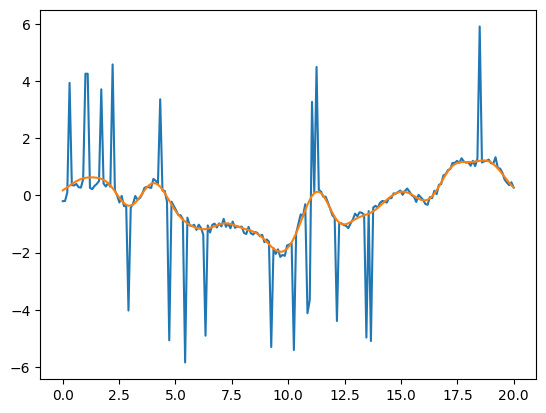

In [45]:
sigma = tf.Variable(1, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
W = tf.eye(N, N, dtype=tf.float64) * sigma ** 2


def mean_function(X):
    return tf.zeros(tf.shape(X)[0], dtype=tf.float64)


for i in range(1000):
    print(i)
    kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
    K = kernel.matrix(X, X)
    K_plus_W_inv = tf.linalg.inv(K + W)
    K_plus_W_inv_y = K_plus_W_inv @ y
    mean_loo = tf.squeeze(y) - tf.squeeze(K_plus_W_inv_y) * (1 / tf.linalg.diag_part(K_plus_W_inv))
    sigma_loo = 1 / tf.linalg.diag_part(K_plus_W_inv)
    vv = tfp.distributions.Normal(mean_loo, sigma_loo)
    LOO_probs=vv.log_prob(tf.squeeze(y))
    LOO_probs=tf.exp(LOO_probs)/tf.reduce_mean(tf.exp(LOO_probs))

    with tf.GradientTape(persistent=True) as tape:
        #estimate Gpflow kernel.
        W = tf.linalg.tensor_diag(tf.reduce_mean(LOO_probs) / LOO_probs)
        K = kernel.matrix(X, X)
        K_plus_W_inv = tf.linalg.inv(K + W)
        K_plus_W_inv_y = K_plus_W_inv @ y
        mean_loo = tf.squeeze(y) - tf.squeeze(K_plus_W_inv_y) * (1 / tf.linalg.diag_part(K_plus_W_inv))
        loss=tf.reduce_sum((tf.squeeze(y)-mean_loo)**2)
    grad = tape.gradient(loss, [ variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [variance, lengthscale]))
    print([sigma, variance, lengthscale])
pred_LOO_margprob = K @ K_plus_W_inv @ y
plt.plot(X,y)
plt.plot(X,pred_LOO_margprob)

In [47]:
#variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
#lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
mu_alpha_inv=tf.constant([1]*N, dtype=tf.float64)

def update_mu_alpha(mu_f,sigma_f_diag,y):
    diff=tf.squeeze(y-mu_f)**2/8+sigma_f_diag
    return ((diff)**0.5+1)
def update_mu_alpha_inv(mu_f,sigma_f_diag,y):
    diff=tf.squeeze(y-mu_f)**2/8+sigma_f_diag
    return (1/diff)**0.5
    
#const_22=8
for i in range(50):
    print(i)

    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X, X)
        W=tf.linalg.diag(1/mu_alpha_inv)*8
        
        mu_f = tf.zeros_like(tf.squeeze(y), dtype=tf.float64)
        Sigma_f= tf.linalg.inv(K+W)
# Multivariate normal distribution
        vv = tfp.distributions.MultivariateNormalFullCovariance(loc=mu_f, covariance_matrix=Sigma_f)

# Compute log-probability and return a scalar
        loss = tf.reduce_sum(vv.log_prob(tf.squeeze(y)))

    grad = tape.gradient(loss, [ variance, lengthscale])
    print( [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [ variance, lengthscale,]))
    #update alpha
    K = kernel.matrix(X, X)
    W=tf.linalg.diag(1/mu_alpha_inv)*8
    K_plus_W_inv=tf.linalg.inv(K+W)
    mu_f=K@K_plus_W_inv@y
    mu_alpha_inv=update_mu_alpha_inv(mu_f,tf.linalg.diag_part(Sigma_f),y)
    mu_alpha=update_mu_alpha(mu_f,tf.linalg.diag_part(Sigma_f),y)
K = kernel.matrix(X, X)
W=tf.linalg.diag(mu_alpha_inv)
K_plus_W_inv=tf.linalg.inv(K+W)
pred_lap_marginal=K@K_plus_W_inv@y

0
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.400993127719253>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.649045368051882>]
1
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.401993121042908>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.6500453613753806>]
2
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.4029931143665635>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.6510453546988815>]
3
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.4039931076902203>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.652045348022382>]
4
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.404993101013878>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.6530453413458835>]
5
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.4059930943375372>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.6540453346693854>]
6
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.40

In [13]:
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
mu_alpha_inv=tf.constant([1]*N, dtype=tf.float64)

def update_mu_alpha(mu_f,sigma_f_diag,y):
    diff=tf.squeeze(y-mu_f)**2/8+sigma_f_diag
    return ((diff)**0.5+1)
def update_mu_alpha_inv(mu_f,sigma_f_diag,y):
    diff=tf.squeeze(y-mu_f)**2/8+sigma_f_diag
    return (1/diff)**0.5
    
for i in range(1000):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.1)
        n_test = X_test.shape[0]
        
        #estimate Gpflow kernel.
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X_train, X_train)
        mu_alpha_inv_t=tf.gather(mu_alpha_inv, train_indices)
        W=tf.linalg.diag(1/mu_alpha_inv_t)*8
        
        
        K_star = tf.transpose(kernel.matrix(X_test, X_train))
        K_star_star = kernel.matrix(X_test, X_test)

        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K+W) @ Y_train
        loss=tf.reduce_sum((Y_test-mu_f_pred)**2)
    grad = tape.gradient(loss, [ variance, lengthscale])
    print( [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [ variance, lengthscale,]))
    #update alpha
    
    K = kernel.matrix(X, X)
    W=tf.linalg.diag(1/mu_alpha_inv)*8
    K_plus_W_inv=tf.linalg.inv(K+W)
    mu_f=K@K_plus_W_inv@y
    Sigma_f= tf.linalg.inv(K+W)
    mu_alpha_inv=update_mu_alpha_inv(mu_f,tf.linalg.diag_part(Sigma_f),y)
    mu_alpha=update_mu_alpha(mu_f,tf.linalg.diag_part(Sigma_f),y)
    
K = kernel.matrix(X, X)   
W=tf.linalg.diag(1/mu_alpha_inv)*8
K_plus_W_inv=tf.linalg.inv(K+W)
pred_lap_loss=K@K_plus_W_inv@y

0
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>]
1
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999317400126>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999301600386>]
2
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998633377265>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999860383222>]
3
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997952341693>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999790903827>]
4
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999727608824>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999722408615>]
5
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4049999659508447>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4049999652631742>]
6
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4059999590951206>, <tf.

In [15]:
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
mu_alpha_inv=tf.constant([1]*N, dtype=tf.float64)

def update_mu_alpha(mu_f,sigma_f_diag,y,b_squared):
    diff=(tf.squeeze(y-mu_f)**2+sigma_f_diag)/b_squared
    return ((diff)**0.5+1)
def update_mu_alpha_inv(mu_f,sigma_f_diag,y,b_squared):
    diff=(tf.squeeze(y-mu_f)**2+sigma_f_diag)/b_squared
    return (1/diff)**0.5
    
b_squared=1.
for i in range(1000):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.2, seed=1)
        n_test = X_test.shape[0]
        
        #estimate Gpflow kernel.
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        K = kernel.matrix(X_train, X_train)
        mu_alpha_inv_t=tf.gather(mu_alpha_inv, train_indices)
        W=tf.linalg.diag(1/mu_alpha_inv_t*b_squared)
        
        
        K_star = tf.transpose(kernel.matrix(X_test, X_train))
        K_star_star = kernel.matrix(X_test, X_test)

        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K+W) @ Y_train
        loss=tf.reduce_sum(abs(Y_test-mu_f_pred))
    grad = tape.gradient(loss, [ variance, lengthscale])
    print( [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [ variance, lengthscale,]))
    #update alpha
    
    K = kernel.matrix(X, X)
    W=tf.linalg.diag(1/mu_alpha_inv)*8
    K_plus_W_inv=tf.linalg.inv(K+W)
    mu_f=K@K_plus_W_inv@y
    Sigma_f=tf.linalg.inv(K+W)
    b_squared=tf.reduce_mean(tf.squeeze(y-mu_f)**2+tf.linalg.diag_part(Sigma_f)*mu_alpha_inv)
    mu_alpha_inv=update_mu_alpha_inv(mu_f,tf.linalg.diag_part(Sigma_f),y,b_squared)

    
K = kernel.matrix(X, X)  
W=tf.linalg.diag(1/mu_alpha_inv)*8
K_plus_W_inv=tf.linalg.inv(K+W)
pred_lap_absLoss=K@K_plus_W_inv@y

0
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>]
1
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999319135027>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999318036345>]
2
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998640624135>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998625767325>]
3
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40299997962561246>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999793461842>]
4
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999728561471>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999724548691>]
5
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4049999660824943>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40499996556286666>]
6
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4059999593150847>, <t

In [16]:
print(tf.reduce_mean((f-pred_lap_absLoss)**2),tf.reduce_mean(abs(f-pred_lap_absLoss)),"Laplace absloss")

tf.Tensor(0.013530606808250306, shape=(), dtype=float64) tf.Tensor(0.09807722430659205, shape=(), dtype=float64) Laplace absloss


In [40]:
variance = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))
lengthscale = tf.Variable(0.4, dtype=tf.float64, constraint=lambda z: tf.clip_by_value(z, 0.001, 10))

N = X.shape[0]
mu_alpha_inv=tf.constant([1]*N, dtype=tf.float64)

def update_mu_alpha(mu_f,sigma_f_diag,y):
    diff=tf.squeeze(y-mu_f)**2/8+sigma_f_diag
    return ((diff)**0.5+1)
@tf.function
def update_mu_alpha_inv(mu_f,sigma_f_diag,y):
    diff=tf.squeeze(y-mu_f)**2/8+sigma_f_diag
    return (1/diff)**0.5
    
for i in range(1000):
    print(i)
    with tf.GradientTape(persistent=True) as tape:
        #create batch for the iteration
        X_train, Y_train, X_test, Y_test, train_indices, test_indices = divide_batch(X, y, test_ratio=0.2, seed=1)
        n_test = X_test.shape[0]
        
        #estimate Gpflow kernel.
        
        kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(variance, lengthscale)
        
        K = kernel.matrix(X, X)
        W=tf.linalg.diag(1/mu_alpha_inv)*8
        K_plus_W_inv=tf.linalg.inv(K+W)
        mu_f=K@K_plus_W_inv@y
        Sigma_f=tf.linalg.inv(K+W)
        mu_alpha_inv=update_mu_alpha_inv(mu_f,tf.linalg.diag_part(Sigma_f),y)
        
        K = kernel.matrix(X_train, X_train)
        mu_alpha_inv_t=tf.gather(mu_alpha_inv, train_indices)
        W=tf.linalg.diag(1/mu_alpha_inv_t)*8
        
        
        K_star = tf.transpose(kernel.matrix(X_test, X_train))
        K_star_star = kernel.matrix(X_test, X_test)

        mu_f_pred = tf.transpose(K_star) @ tf.linalg.inv(K+W) @ Y_train
        """sigma_f_pred=K_star_star-tf.transpose(K_star) @tf.linalg.inv(K+W)@K_star
        vv = tfp.distributions.MultivariateNormalFullCovariance(mu_f_pred, sigma_f_pred)
        loss = vv.log_prob(tf.squeeze(Y_test))
        """
        loss=tf.reduce_sum(abs(Y_test-mu_f_pred))
    grad = tape.gradient(loss, [ variance, lengthscale])
    print( [variance, lengthscale])
    optimizer = tf.optimizers.Adam()
    optimizer.apply_gradients(zip(grad, [ variance, lengthscale,]))
    #update alpha
    

    
K = kernel.matrix(X, X)   
W=tf.linalg.diag(1/mu_alpha_inv)*8
K_plus_W_inv=tf.linalg.inv(K+W)
pred_lap_absloss_trackalpha=K@K_plus_W_inv@y

0
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4>]
1
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999320531077>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40099999309231343>]
2
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40199998639443824>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4019999861302551>]
3
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999795890986>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4029999791862414>]
4
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40399997277773086>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4039999722099264>]
5
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40499996598260635>, <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.40499996528921384>]
6
[<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4059999591854904>, <t

In [26]:

from typing import Optional

import tensorflow as tf
import numpy as np
from check_shapes import check_shapes, inherit_check_shapes
from typing import Optional, Tuple, Type, Union, cast

import gpflow

from gpflow.base import InputData, MeanAndVariance, RegressionData, TensorData
from gpflow.kernels import Kernel
from gpflow.likelihoods import Gaussian
from gpflow.mean_functions import MeanFunction
from gpflow.models.model import GPModel
from gpflow.models.training_mixins import InternalDataTrainingLossMixin
from gpflow.models.util import data_input_to_tensor
from gpflow.config import default_float, default_jitter
from gpflow.utilities import to_default_float
from gpflow import posteriors
from gpflow.utilities.ops import eye


from typing import Any, Callable
import tensorflow as tf
from check_shapes import check_shapes

from gpflow.base import TensorType
from gpflow.likelihoods import Gaussian


def assert_params_false(
    called_method: Callable[..., Any],
    **kwargs: bool,
) -> None:

    errors_str = ", ".join(f"{param}={value}" for param, value in kwargs.items() if value)
    if errors_str:
        raise NotImplementedError(
            f"{called_method.__qualname__} does not currently support: {errors_str}"
        )


def add_noise_cov(K: tf.Tensor, W: tf.Tensor, likelihood_variance: TensorType) -> tf.Tensor:

    k_diag = tf.linalg.diag_part(K)
    return tf.linalg.set_diag(K, k_diag + likelihood_variance*(W**-2))


def add_likelihood_noise_cov(K: tf.Tensor, W: tf.Tensor, likelihood: Gaussian, X: TensorType) -> tf.Tensor:
    W_squeeze = tf.squeeze(W, axis=-1)
    variance_squeeze = tf.squeeze(likelihood.variance_at(X), axis=-1)
    return add_noise_cov(K, W_squeeze, variance_squeeze)



class RCGPR_deprecated(GPModel, InternalDataTrainingLossMixin):
    """
    Robust and Conjugate Gaussian Process Regression
    This method only works with a Gaussian likelihood, its variance is
    initialized to `noise_variance`.
    """
    @check_shapes(
        "data[0]: [N, D]",
        "data[1]: [N, P]",
        "noise_variance: []",
    )
    def __init__(
        self,
        data: RegressionData,
        kernel: Kernel,
        weighting_function,
        mean_function: Optional[MeanFunction] = None,
        noise_variance: Optional[TensorData] = None,
        likelihood: Optional[Gaussian] = None,
    ):
        assert (noise_variance is None) or (
            likelihood is None
        ), "Cannot set both `noise_variance` and `likelihood`."
        if likelihood is None:
            if noise_variance is None:
                noise_variance = 1.0
            likelihood = gpflow.likelihoods.Gaussian(noise_variance)
        _, Y_data = data
        super().__init__(kernel, likelihood, mean_function, num_latent_gps=Y_data.shape[-1])
        self.data = data_input_to_tensor(data)
        self.weighting_function = weighting_function

    @inherit_check_shapes
    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        return self.loo_cv()

    @check_shapes(
        "return: []",
    )
    def log_marginal_likelihood(self) -> tf.Tensor:
        r"""
        Computes the log pseudo smarginal likelihood.

        """
        X, Y = self.data
        n = tf.shape(X)[0]
        K = self.kernel(X)
        W = self.weighting_function.W(X, Y)
        W_dy = self.weighting_function.dy(X, Y)

        K_plus_sW = add_likelihood_noise_cov(K, W, self.likelihood, X)
        L_plus_sW = tf.linalg.cholesky(K_plus_sW + tf.eye(n, dtype=default_float()) * 1e-04)

        nu = (self.likelihood.variance_at(X)**-1)*Y*(W**2)-2*W*W_dy

        A = tf.linalg.triangular_solve(L_plus_sW, tf.transpose(tf.linalg.matmul(nu, K, transpose_a=True)), lower=True)
        B = tf.linalg.triangular_solve(L_plus_sW, nu*(W**-2)*self.likelihood.variance_at(X), lower=True)

        C1 = tf.matmul(Y, Y*(W**2)*self.likelihood.variance_at(X)**-1, transpose_a=True)/2
        C2 = - tf.matmul(Y, W*W_dy, transpose_a=True)
        C3 = - tf.matmul(W, W, transpose_a=True)

        C = tf.reduce_sum(C1+C2+C3)

        D1 = tf.reduce_sum(tf.math.log(tf.linalg.diag_part(L_plus_sW)))
        D2 = tf.reduce_sum(tf.math.log((W**2)*self.likelihood.variance_at(X)**-1))/2

        D = tf.reduce_sum(D1+D2) 

        return tf.reduce_sum(tf.linalg.matmul(A, B, transpose_a=True))/2 - C - D

    def loo_cv(self) -> tf.Tensor:
        r"""
        Computes the leave one out to train the model
        """
        X, Y = self.data
        err = Y - self.mean_function(X)
        K = self.kernel(X)
        n = tf.cast(tf.shape(X)[0], K.dtype)
        likelihood_variance = self.likelihood.variance_at(X)
        W, W_dy = self.weighting_function.w_dy(X, err)
        dylog2 = 2*likelihood_variance*W_dy/W
        Y_bar = err - dylog2

        K_sW = add_noise_cov(K, tf.squeeze(W, axis=-1), tf.squeeze(likelihood_variance, axis=-1))
        L_sW = tf.linalg.cholesky(K_sW)
        L_sW_inv = tf.linalg.inv(L_sW)

        #K_sW_inv = tf.linalg.matmul(L_sW_inv, L_sW_inv, transpose_a=True)

        #diag_K_sW_inv = tf.reshape(tf.linalg.diag_pxart(K_sW_inv), (-1, 1))
        diag_K_sW_inv = tf.reshape(tf.reduce_sum(L_sW_inv**2, axis=0), (-1, 1))

        A = diag_K_sW_inv*dylog2
        
        #B = tf.matmul(K_sW_inv, Y_bar)
        B = tf.matmul(L_sW_inv, tf.matmul(L_sW_inv, Y_bar), transpose_a=True)
        C = diag_K_sW_inv * (1-diag_K_sW_inv*(likelihood_variance*(W**-2) - likelihood_variance))

        D = C/diag_K_sW_inv**2

        loo = - 0.5 * tf.reduce_sum(tf.math.log(D))
        loo -= 0.5 * n * np.log(2 * np.pi)
        loo -= 0.5 * tf.reduce_sum((A+B)**2/C)
        return loo

    @inherit_check_shapes
    def predict_f(
        self, Xnew: InputData, full_cov: bool = False, full_output_cov: bool = False
    ) -> MeanAndVariance:
        
        X, Y = self.data
        err = Y - self.mean_function(X)
        m = tf.shape(X)[0]

        W = self.weighting_function.W(X, err)
        W_dy = self.weighting_function.dy(X, err)

        likelihood_variance = self.likelihood.variance_at(X)

        kmm = self.kernel(X)
        knn = self.kernel(Xnew, full_cov=full_cov)
        kmn = self.kernel(X, Xnew)
        kmm_plus_sW = add_likelihood_noise_cov(kmm, W, self.likelihood, X)

        Lm_plus_sW = tf.linalg.cholesky(kmm_plus_sW
                                        + tf.eye(m, dtype=default_float())
                                        * 1e-06)

        K = tf.rank(kmn)
        perm = tf.concat(
            [
                tf.reshape(tf.range(1, K - 1), [K - 2]),  # leading dims (...)
                tf.reshape(0, [1]),  # [W]
                tf.reshape(K - 1, [1]),
            ],
            0,
        )  # [N]
        kmn = tf.transpose(kmn, perm)  # [..., W, N]

        leading_dims = tf.shape(kmn)[:-2]

        # Compute the projection matrix A
        Lm_plus_sW = tf.broadcast_to(Lm_plus_sW, tf.concat([leading_dims, tf.shape(Lm_plus_sW)], 0))  # [..., W, W]
        A = tf.linalg.triangular_solve(Lm_plus_sW, kmn, lower=True)  # [..., W, N]

        # compute kernel stuff
        num_func = tf.shape(err)[-1]  # R
        N = tf.shape(kmn)[-1]

        if full_cov:
            f_var = knn - tf.linalg.matmul(A, A, transpose_a=True)  # [..., N, N]
            cov_shape = tf.concat([leading_dims, [num_func, N, N]], 0)
            f_var = tf.broadcast_to(tf.expand_dims(f_var, -3), cov_shape)  # [..., R, N, N]
        else:
            f_var = knn - tf.reduce_sum(tf.square(A), -2)  # [..., N]
            cov_shape = tf.concat([leading_dims, [num_func, N]], 0)  # [..., R, N]
            f_var = tf.broadcast_to(tf.expand_dims(f_var, -2), cov_shape)  # [..., R, N]

        if not full_cov:
            f_var = tf.linalg.adjoint(f_var)  # [N, R]

        f = err - 2*likelihood_variance*W_dy/W
        B = tf.linalg.triangular_solve(Lm_plus_sW, f, lower=True)  # [..., W, N]
        f_mean_zero = tf.linalg.matmul(A, B, transpose_a=True)

        f_mean = f_mean_zero + self.mean_function(Xnew)

        return f_mean, f_var


class RCGPR_with_posterior(RCGPR_deprecated):
    """
    This is an implementation of GPR that provides a posterior() method that
    enables caching for faster subsequent predictions.
    """

    def posterior(
        self,
        precompute_cache: posteriors.PrecomputeCacheType = posteriors.PrecomputeCacheType.TENSOR,
    ):
        """
        Create the Posterior object which contains precomputed matrices for
        faster prediction.

        precompute_cache has three settings:

        - `PrecomputeCacheType.TENSOR` (or `"tensor"`): Precomputes the cached
          quantities and stores them as tensors (which allows differentiating
          through the prediction). This is the default.
        - `PrecomputeCacheType.VARIABLE` (or `"variable"`): Precomputes the cached
          quantities and stores them as variables, which allows for updating
          their values without changing the compute graph (relevant for AOT
          compilation).
        - `PrecomputeCacheType.NOCACHE` (or `"nocache"` or `None`): Avoids
          immediate cache computation. This is useful for avoiding extraneous
          computations when you only want to call the posterior's
          `fused_predict_f` method.
        """

        return RCGPPosterior(
            kernel=self.kernel,
            data=self.data,
            weighting_function=self.weighting_function,
            likelihood=self.likelihood,
            mean_function=self.mean_function,
            precompute_cache=precompute_cache,
        )

    @inherit_check_shapes
    def predict_f(
        self, Xnew: InputData, full_cov: bool = False, full_output_cov: bool = False
    ) -> MeanAndVariance:
        """
        For backwards compatibility, GPR's predict_f uses the fused (no-cache)
        computation, which is more efficient during training.

        For faster (cached) prediction, predict directly from the posterior object, i.e.,:
            model.posterior().predict_f(Xnew, ...)
        """
        return self.posterior(posteriors.PrecomputeCacheType.NOCACHE).fused_predict_f(
            Xnew, full_cov=full_cov, full_output_cov=full_output_cov
        )


class RCGPPosterior(posteriors.AbstractPosterior):
    @check_shapes(
        "data[0]: [N, D]",
        "data[1]: [N, Q]",
    )
    def __init__(
        self,
        kernel: Kernel,
        data: RegressionData,
        weighting_function,
        likelihood: Gaussian,
        mean_function: MeanFunction,
        *,
        precompute_cache: Optional[posteriors.PrecomputeCacheType],
    ) -> None:
        X, Y = data
        super().__init__(kernel, X, mean_function=mean_function)
        self.Y_data = Y
        self.likelihood = likelihood
        self.weighting_function = weighting_function

        if precompute_cache is not None:
            self.update_cache(precompute_cache)

    @inherit_check_shapes
    def _conditional_with_precompute(
        self,
        cache: Tuple[tf.Tensor, ...],
        Xnew,
        full_cov: bool = False,
        full_output_cov: bool = False,
    ) -> MeanAndVariance:
        """
        Computes predictive mean and (co)variance at Xnew, *excluding* mean_function.
        Relies on cached alpha and Qinv.
        """
        err, Lm_plus_sW, W, W_dy, likelihood_variance = cache

        knn = self.kernel(Xnew, full_cov=full_cov)
        kmn = self.kernel(self.X_data, Xnew)


        K = tf.rank(kmn)
        perm = tf.concat(
            [
                tf.reshape(tf.range(1, K - 1), [K - 2]),  # leading dims (...)
                tf.reshape(0, [1]),  # [W]
                tf.reshape(K - 1, [1]),
            ],
            0,
        )  # [N]
        kmn = tf.transpose(kmn, perm)  # [..., W, N]

        leading_dims = tf.shape(kmn)[:-2]
        M = tf.shape(err)[-2]

        # Compute the projection matrix A
        Lm_plus_sW = tf.broadcast_to(Lm_plus_sW, tf.concat([leading_dims, tf.shape(Lm_plus_sW)], 0))  # [..., W, W]
        A = tf.linalg.triangular_solve(Lm_plus_sW, kmn, lower=True)  # [..., W, N]

        # compute kernel stuff
        num_func = tf.shape(err)[-1]  # R
        N = tf.shape(kmn)[-1]

        if full_cov:
            f_var = knn - tf.linalg.matmul(A, A, transpose_a=True)  # [..., N, N]
            cov_shape = tf.concat([leading_dims, [num_func, N, N]], 0)
            f_var = tf.broadcast_to(tf.expand_dims(f_var, -3), cov_shape)  # [..., R, N, N]
        else:
            f_var = knn - tf.reduce_sum(tf.square(A), -2)  # [..., N]
            cov_shape = tf.concat([leading_dims, [num_func, N]], 0)  # [..., R, N]
            f_var = tf.broadcast_to(tf.expand_dims(f_var, -2), cov_shape)  # [..., R, N]

        if not full_cov:
            f_var = tf.linalg.adjoint(f_var)  # [N, R]

        A = tf.linalg.triangular_solve(tf.linalg.adjoint(Lm_plus_sW), A, lower=False)
  
        f = err - 2*likelihood_variance*W_dy/W
        f_shape = tf.concat([leading_dims, [M, num_func]], 0)  # [..., M, R]
        f = tf.broadcast_to(f, f_shape)

        f_mean = tf.linalg.matmul(A, f, transpose_a=True)

        return f_mean, f_var

    def _precompute(self) -> Tuple[posteriors.PrecomputedValue, ...]:
        assert self.mean_function is not None
        X_data = cast(tf.Tensor, self.X_data)
        err = self.Y_data - self.mean_function(X_data)
        
        D = err.shape[1]
        M = X_data.shape[0]
        D_dynamic = D is None
        M_dynamic = M is None

        W = self.weighting_function.W(X_data, err)
        W_dy = self.weighting_function.dy(X_data, err)

        likelihood_variance = self.likelihood.variance_at(self.X_data)

        kmm = self.kernel(X_data)
        kmm_plus_sW = add_likelihood_noise_cov(kmm, W, self.likelihood, X_data) + eye(
            tf.shape(X_data)[-2], value=default_jitter(), dtype=default_float()
        )

        Lm_plus_sW = tf.linalg.cholesky(kmm_plus_sW)

        return (
            posteriors.PrecomputedValue(err, (M_dynamic, D_dynamic)),
            posteriors.PrecomputedValue(Lm_plus_sW, (M_dynamic, M_dynamic)),
            posteriors.PrecomputedValue(W, (M_dynamic, D_dynamic)),
            posteriors.PrecomputedValue(W_dy, (M_dynamic, D_dynamic)),
            posteriors.PrecomputedValue(likelihood_variance, (M_dynamic, D_dynamic)),
        )

    @inherit_check_shapes
    def _conditional_fused(
        self, Xnew, full_cov: bool = False, full_output_cov: bool = False
    ) -> MeanAndVariance:
        """
        Computes predictive mean and (co)variance at Xnew, *excluding* mean_function
        Does not make use of caching
        """
        temp_cache = tuple(c.value for c in self._precompute())
        return self._conditional_with_precompute(temp_cache, Xnew, full_cov, full_output_cov)


class RCGPR(RCGPR_with_posterior):
    __doc__ = RCGPR_deprecated.__doc__ 


In [27]:
model = RCGPR(
    (X, y),
    kernel=gpflow.kernels.SquaredExponential(),
    weighting_function= w.IMQ(1),
    noise_variance=standard_gp.likelihood.variance)

In [28]:
gpflow.set_trainable(model.likelihood.variance, True)
opt = gpflow.optimizers.Scipy()
opt_options = dict()
res = opt.minimize(model.training_loss_closure(), model.trainable_variables, options=opt_options)
gpflow.utilities.print_summary(model, "notebook")

f_mean_dsm, f_var_dsm = model.predict_f(X, full_cov=False)

name,class,transform,prior,trainable,shape,dtype,value
RCGPR.kernel.variance,Parameter,Softplus,,True,(),float64,2.23971
RCGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.174917
RCGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.781696
RCGPR.weighting_function.C,Parameter,Softplus,,True,(),float64,0.888631


In [48]:
print(tf.reduce_mean((f_mean_dsm-f)**2),tf.reduce_mean(abs(f-f_mean_dsm)),"rcgp mean")
print(tf.reduce_mean((f-f_mean)**2),tf.reduce_mean(abs(f-f_mean)),"normal mean")
print(tf.reduce_mean((f-pred_LOO_cprop_MSE)**2),tf.reduce_mean(abs(f-pred_LOO_cprop_MSE)),"pred_LOO_cprop_MSE")
print(tf.reduce_mean((f-pred_LOO_cmax)**2),tf.reduce_mean(abs(f-pred_LOO_cmax)),"pred_LOO_c maximized")
print(tf.reduce_mean((f-pred_LOO_c_2sigma)**2),tf.reduce_mean(abs(f-pred_LOO_c_2sigma)),"pred_LOO_ c =2*sigma")
print(tf.reduce_mean((f-pred_LOO_margprob)**2),tf.reduce_mean(abs(f-pred_LOO_margprob)),"pred_LOO_ weights given by marginal prob")
print(tf.reduce_mean((f-Mu_full)**2),tf.reduce_mean(abs(f-Mu_full)),"rcgp_alpha mean")
print(tf.reduce_mean((f-pred_01)**2),tf.reduce_mean(abs(f-pred_01)),"LOO_cprop_MSE+VAr")
print(tf.reduce_mean((f-pred_lap_loss)**2),tf.reduce_mean(abs(f-pred_lap_loss)),"laplace mse")
print(tf.reduce_mean((f-pred_lap_marginal)**2),tf.reduce_mean(abs(f-pred_lap_marginal)),"Laplace Marginal ")
print(tf.reduce_mean((f-pred_lap_absLoss)**2),tf.reduce_mean(abs(f-pred_lap_absLoss)),"Laplace absloss")
print(tf.reduce_mean((f-pred_lap_absloss_trackalpha)**2),tf.reduce_mean(abs(f-pred_lap_absloss_trackalpha)),"Laplace absloss+track")

tf.Tensor(0.22498506960267228, shape=(), dtype=float64) tf.Tensor(0.4322596205037398, shape=(), dtype=float64) rcgp mean
tf.Tensor(0.2128135237527253, shape=(), dtype=float64) tf.Tensor(0.3607827732709825, shape=(), dtype=float64) normal mean
tf.Tensor(0.02812626810078979, shape=(), dtype=float64) tf.Tensor(0.12494837517477098, shape=(), dtype=float64) pred_LOO_cprop_MSE
tf.Tensor(0.0027064482057216044, shape=(), dtype=float64) tf.Tensor(0.04488325412265159, shape=(), dtype=float64) pred_LOO_c maximized
tf.Tensor(0.03423028469386283, shape=(), dtype=float64) tf.Tensor(0.13755590635591056, shape=(), dtype=float64) pred_LOO_ c =2*sigma
tf.Tensor(0.008135160120363439, shape=(), dtype=float64) tf.Tensor(0.0674416058989617, shape=(), dtype=float64) pred_LOO_ weights given by marginal prob
tf.Tensor(0.04124719239653414, shape=(), dtype=float64) tf.Tensor(0.14144381674394513, shape=(), dtype=float64) rcgp_alpha mean
tf.Tensor(0.0429932582330528, shape=(), dtype=float64) tf.Tensor(0.1612327625

2.2597214991723016

In [52]:
c

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0920002301553122>